In [ ]:
# GOOGLECOLAB NOTEBOOK

In [ ]:
from PIL import Image
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import pickle
import tqdm
import random
import os

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install google-colab

In [ ]:
a=6

In [ ]:
root_path = 'gdrive/My Drive/dataset/'

In [ ]:
# DATASET

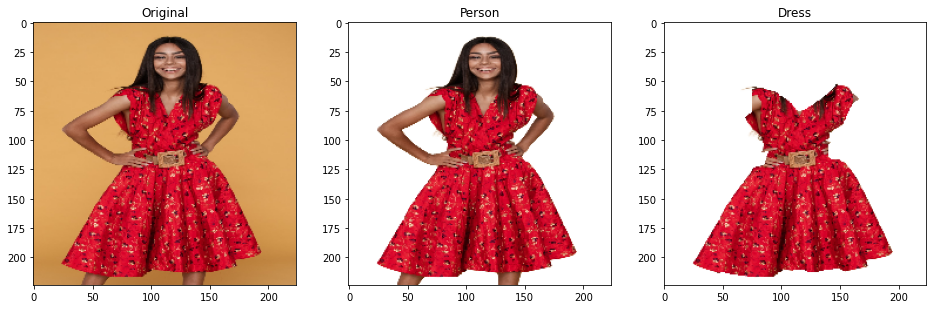

In [ ]:
### PLOT ONE SAMPLE OF IMAGE IN THE DATA ###
original = cv.imread(root_path+'dl2/o1.jpg')
original = cv.resize(original,(224,224))
dress = cv.imread(root_path+'dl2/d1.jpg')
dress = cv.resize(dress,(224,224))
body = cv.imread(root_path+'dl2/b1.jpg')
body = cv.resize(body,(224,224))

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(cv.cvtColor(original, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,2)
plt.title('Person')
plt.imshow(cv.cvtColor(body, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,3)
plt.title('Dress')
plt.imshow(cv.cvtColor(dress, cv.COLOR_BGRA2RGB))

In [ ]:
# PREPARE IMAGES FOR SEGMENTATION

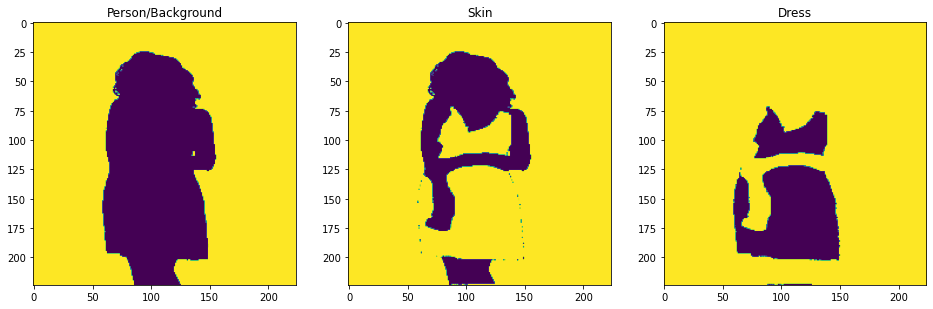

In [ ]:
dress = cv.imread(root_path+'dl2/d2.jpg',0)
body = cv.imread(root_path+'dl2/b2.jpg',0)

### ENCODE DRESS ###
dress[dress == 255] = 0
dress[dress > 0] = 255
dress = cv.resize(dress,(224,224))

### ENCODE BODY ###
body[body == 255] = 0
body[body > 0] = 255
body = cv.resize(body,(224,224))

### ENCODE SKIN ###
skin = body - dress


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Person/Background')
bg = (255 - body)/255
plt.imshow(bg)
plt.subplot(1,3,2)
plt.title('Skin')
skin = (255 - skin)/255
plt.imshow(skin)
plt.subplot(1,3,3)
plt.title('Dress')
dress = (255 - dress)/255
plt.imshow(dress)

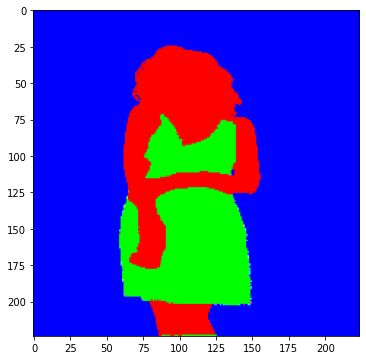

In [ ]:
### COMBINE BACKGROUND, SKIN, DRESS ###
gt = np.zeros((224,224,3))
gt[:,:,0] = (1-skin)
gt[:,:,1] = (1-dress)
gt[:,:,2] = bg

plt.figure(figsize=(6,6))
plt.imshow(gt)

100%|██████████| 17/17 [00:35<00:00,  2.08s/it]


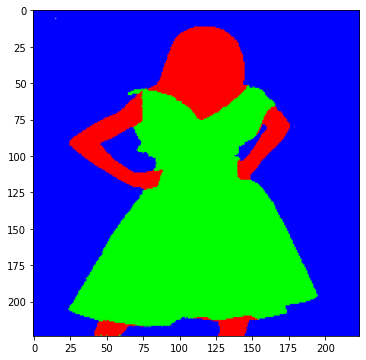

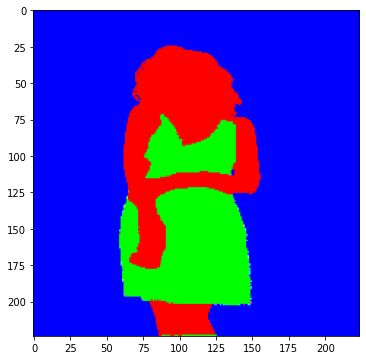

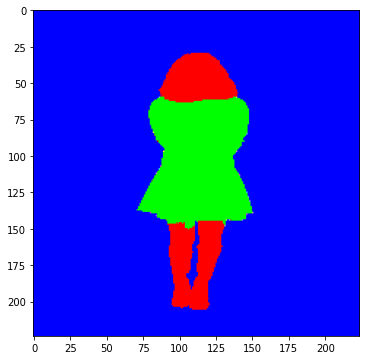

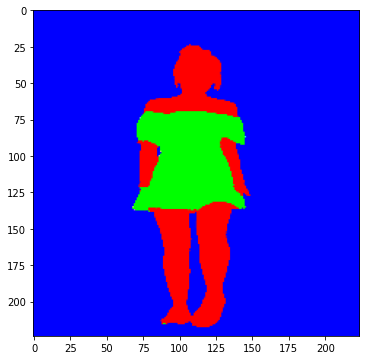

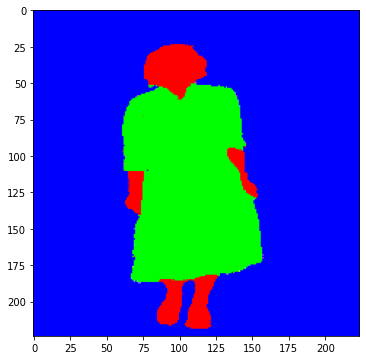

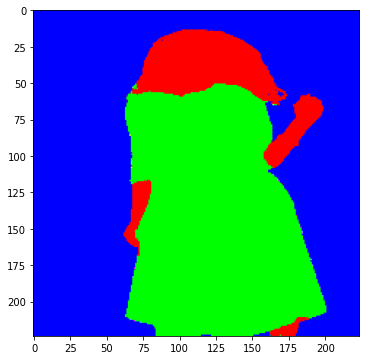

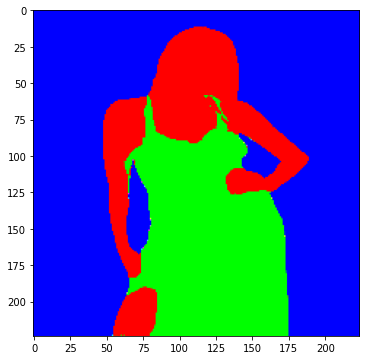

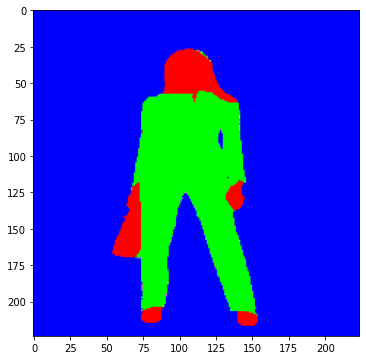

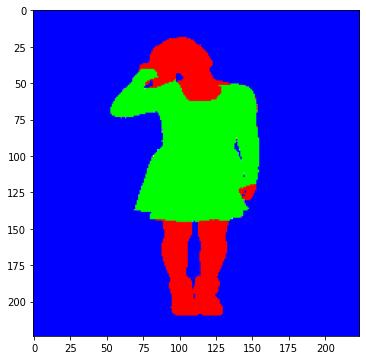

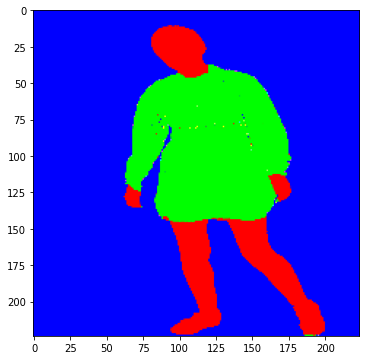

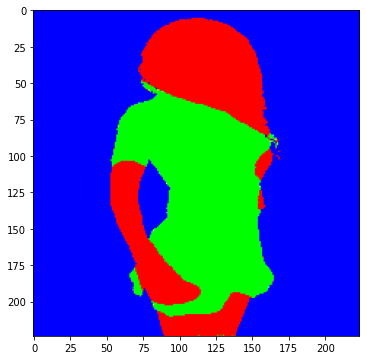

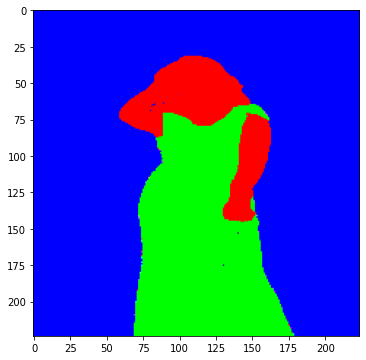

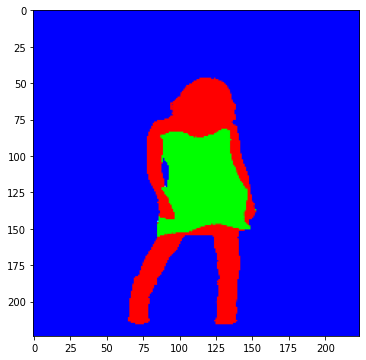

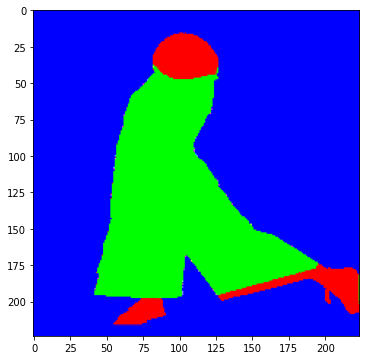

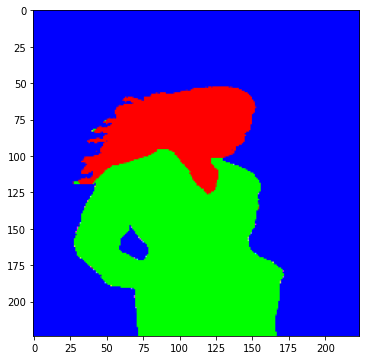

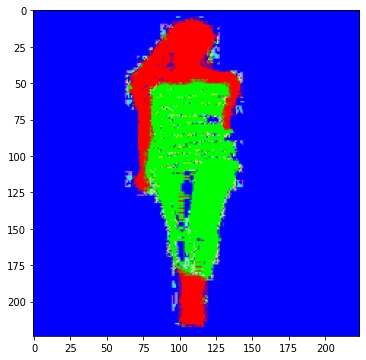

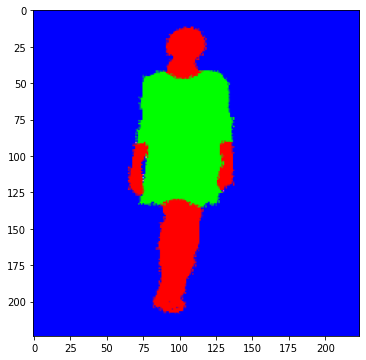

In [ ]:
### ENCODE BACKGROUND, SKIN, DRESS FOR ALL TRAIN IMAGES ###

images_original = []
images_gt = []

mean = np.zeros((224,224,3))
n_img = 17

for i in tqdm.tqdm(range(1,n_img+1)):
    
    original = cv.imread(root_path+'dl2/o'+str(i)+'.jpg')
    original = cv.resize(original,(224,224))
    images_original.append(original)
    mean[:,:,0]=mean[:,:,0]+original[:,:,0]
    mean[:,:,1]=mean[:,:,1]+original[:,:,1]
    mean[:,:,2]=mean[:,:,2]+original[:,:,2]
    
    body = cv.imread(root_path+'dl2/b'+str(i)+'.jpg',0)
    dress = cv.imread(root_path+'dl2/d'+str(i)+'.jpg',0)
    
    dress[dress == 255] = 0
    dress[dress > 0] = 255
    dress = cv.resize(dress,(224,224))

    body[body == 255] = 0
    body[body > 0] = 255
    body = cv.resize(body,(224,224))

    skin = body - dress
    bg = (255 - body)/255
    skin = (255 - skin)/255
    dress = (255 - dress)/255
    
    gt = np.zeros((224,224,3))
    gt[:,:,0] = (1-skin)
    gt[:,:,1] = (1-dress)
    gt[:,:,2] = bg
    plt.figure(figsize=(6,6))
    plt.imshow(gt)
   
    images_gt.append(gt)

mean = mean / n_img
mean = mean.astype('int')

In [ ]:
pickle.dump(mean, open(root_path+"mean81.pkl", "wb"))

In [ ]:
# TRAIN UNET

In [ ]:
def custom_activation(x):
    return K.relu(x, alpha=0.0, max_value=1)


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

smooth = 1.

In [ ]:
def get_unet(do=0, activation=ReLU):
  
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['accuracy'])

    return model

In [ ]:
model = get_unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, None, None, 3 0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, None, 3 0           re_lu[0][0]                      
_______________________________________________________________________________________

In [ ]:
x_raw = np.asarray(images_original) - mean.reshape(-1,224,224,3) 
x_gt = np.asarray(images_gt).reshape(-1,224,224,3) 

In [ ]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



### TRAIN UNET ###
model = get_unet()
model.fit(x_raw, x_gt, epochs=120)

Epoch 1/120
1/1 [==============================] - 0s 6ms/step - loss: 1.7067 - accuracy: 0.5085
Epoch 2/120
1/1 [==============================] - 0s 166ms/step - loss: 1.1008 - accuracy: 0.6893
Epoch 3/120
1/1 [==============================] - 0s 167ms/step - loss: 0.7891 - accuracy: 0.7253
Epoch 4/120
1/1 [==============================] - 0s 167ms/step - loss: 0.6542 - accuracy: 0.7229
Epoch 5/120
1/1 [==============================] - 0s 166ms/step - loss: 0.6413 - accuracy: 0.7229
Epoch 6/120
1/1 [==============================] - 0s 164ms/step - loss: 0.5930 - accuracy: 0.7200
Epoch 7/120
1/1 [==============================] - 0s 166ms/step - loss: 0.5368 - accuracy: 0.7111
Epoch 8/120
1/1 [==============================] - 0s 166ms/step - loss: 0.5117 - accuracy: 0.7081
Epoch 9/120
1/1 [==============================] - 0s 164ms/step - loss: 0.5046 - accuracy: 0.7188
Epoch 10/120
1/1 [==============================] - 0s 166ms/step - loss: 0.4950 - accuracy: 0.7295
Epoch 11/12

In [ ]:
model.save(root_path+'fashion_unet.h5')